<a href="https://colab.research.google.com/github/Jayan565/Project_Data_Led_Trading/blob/main/Data_Led_Trading_(Predictive_Modelling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from google.colab import auth
# import pmdarima as pm

In [ ]:
auth.authenticate_user()

In [ ]:
query = '''
SELECT *
FROM `data-led-trading.eur_usd.eurusd_24h`
'''
df = pd.read_gbq(query, project_id="data-led-trading")
df.head()

<ipython-input-5-3a6b9e2216ef>:5: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query, project_id="data-led-trading")


,Date_date,open,high,low,close,vol
0,2024-01-02 00:00:00+00:00,1.10366,1.10432,1.09375,1.09416,277215
1,2009-02-04 00:00:00+00:00,1.30105,1.30705,1.28125,1.28545,716989
2,2009-11-17 00:00:00+00:00,1.49815,1.49984,1.48048,1.48741,79461
3,2016-10-24 00:00:00+00:00,1.08800,1.08996,1.08596,1.08729,491916
4,2023-10-30 00:00:00+00:00,1.05618,1.06250,1.05471,1.06138,228354


In [ ]:
df = df.sort_values(by='Date_date', ascending=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5014 entries, 2170 to 1880
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date_date  5014 non-null   datetime64[us, UTC]
 1   open       5014 non-null   float64            
 2   high       5014 non-null   float64            
 3   low        5014 non-null   float64            
 4   close      5014 non-null   float64            
 5   vol        5014 non-null   Int64              
dtypes: Int64(1), datetime64[us, UTC](1), float64(4)
memory usage: 279.1 KB


In [ ]:
df.reset_index(inplace=True)
df = df[['Date_date','open','high','low','close','vol']]
df

,Date_date,open,high,low,close,vol
0,2008-10-06 00:00:00+00:00,1.35655,1.35850,1.34430,1.35150,385326
1,2008-10-07 00:00:00+00:00,1.35150,1.37425,1.34815,1.35700,817008
2,2008-10-08 00:00:00+00:00,1.35687,1.37535,1.35429,1.36080,710363
3,2008-10-09 00:00:00+00:00,1.36079,1.37812,1.35528,1.35568,178136
4,2008-10-10 00:00:00+00:00,1.35567,1.36407,1.32592,1.34091,131567
...,...,...,...,...,...,...
5009,2024-10-10 00:00:00+00:00,1.09422,1.09548,1.09000,1.09334,275190
5010,2024-10-11 00:00:00+00:00,1.09335,1.09537,1.09260,1.09353,178701
5011,2024-10-13 00:00:00+00:00,1.09310,1.09335,1.09221,1.09230,7263
5012,2024-10-14 00:00:00+00:00,1.09231,1.09366,1.08881,1.09090,172297


In [ ]:
# Perform the Dickey-Fuller test (check if data is stationary?) - if p > 0.05 then non-stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['close'])
print('p-value:', result[1])

p-value: 0.3071174443224321


In [ ]:
# My understanding:
# fitting the ARIMA model on the original df
# order - AutoRegressive part, integrated part, moving average part) changable
# So uses 1 past value, differentiates the data once and uses 1 past error to improve predictions.



model = ARIMA(df['close'], order=(3, 3, 3))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# forcasting the next 10 days (steps=10)
forecast = model_fit.forecast(steps=10)

In [ ]:
forecast

,predicted_mean
5014,1.090068
5015,1.089403
5016,1.088952
5017,1.088270
5018,1.087463
5019,1.087023
5020,1.086249
5021,1.085518
5022,1.084952
5023,1.084194


In [ ]:
df['Date_date'] = df['Date_date'].dt.tz_localize(None)

In [ ]:
df['Date_date'] = pd.to_datetime(df['Date_date'])
df.set_index('Date_date', inplace=True, drop=False)

In [ ]:
y = df.close
y = y.interpolate()
train, test = y[:int(len(y)*0.8)],y[int(len(y)*0.8):]
y

,close
Date_date,
2008-10-06,1.35150
2008-10-07,1.35700
2008-10-08,1.36080
2008-10-09,1.35568
2008-10-10,1.34091
...,...
2024-10-10,1.09334
2024-10-11,1.09353
2024-10-13,1.09230


In [ ]:
adfuller(y)[1]

0.3071174443224321

In [ ]:
adfuller(y.diff(1).dropna())[1], adfuller(y.diff(1).diff(1).dropna())[1]

(0.0, 0.0)

In [ ]:
d = 1

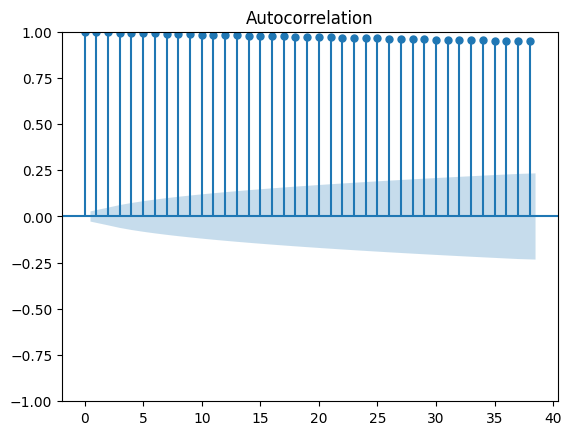

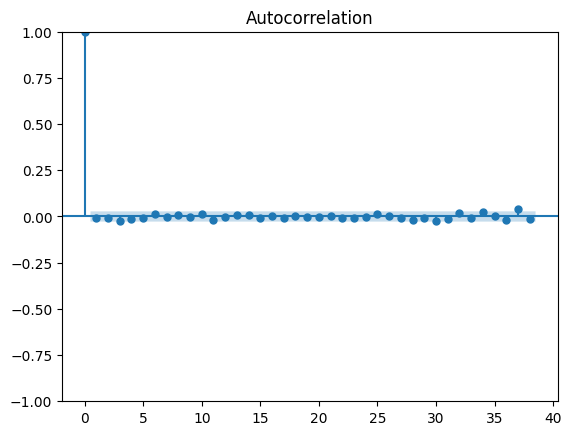

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y);
plot_acf(y.diff(1).dropna());

In [ ]:
q = 1

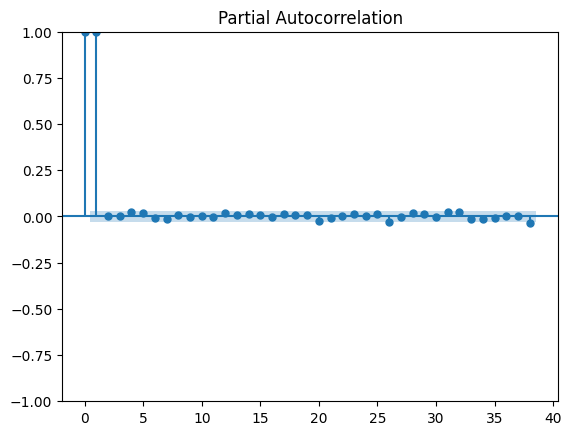

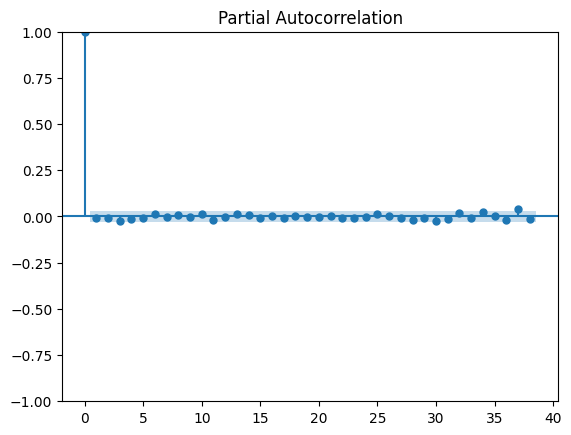

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y);
plot_pacf(y.diff(1).dropna());

In [ ]:
p=1

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.7 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

In [ ]:
model = auto_arima(
    train,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,           # let model determine 'd'
    test='adf',       # using adf test to find optimal 'd'
    trace=True, error_action='ignore',  suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28546.059, Time=0.99 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-28544.207, Time=0.80 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-28544.208, Time=3.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28547.916, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-28542.056, Time=6.64 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 12.839 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [ ]:
prediction = pd.DataFrame(model.predict(n_periods=len(test)))

prediction

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,0
4011,1.18661
4012,1.18661
4013,1.18661
4014,1.18661
4015,1.18661
...,...
5009,1.18661
5010,1.18661
5011,1.18661
5012,1.18661


In [ ]:
prediction

,0
4011,1.18661
4012,1.18661
4013,1.18661
4014,1.18661
4015,1.18661
...,...
5009,1.18661
5010,1.18661
5011,1.18661
5012,1.18661


In [ ]:
prediction.reset_index(inplace = True, drop=True)

In [ ]:
prediction

,0
0,1.18661
1,1.18661
2,1.18661
3,1.18661
4,1.18661
...,...
998,1.18661
999,1.18661
1000,1.18661
1001,1.18661


In [ ]:
prediction_2 = pd.DataFrame(test)
prediction_2.reset_index(inplace=True)
prediction_2["prediction"] = prediction[0]
prediction_2.set_index("Date_date", inplace = True)
prediction_2

,close,prediction
Date_date,,
2021-08-02,1.18740,1.18661
2021-08-03,1.18694,1.18661
2021-08-04,1.18371,1.18661
2021-08-05,1.18332,1.18661
2021-08-06,1.17596,1.18661
...,...,...
2024-10-10,1.09334,1.18661
2024-10-11,1.09353,1.18661
2024-10-13,1.09230,1.18661


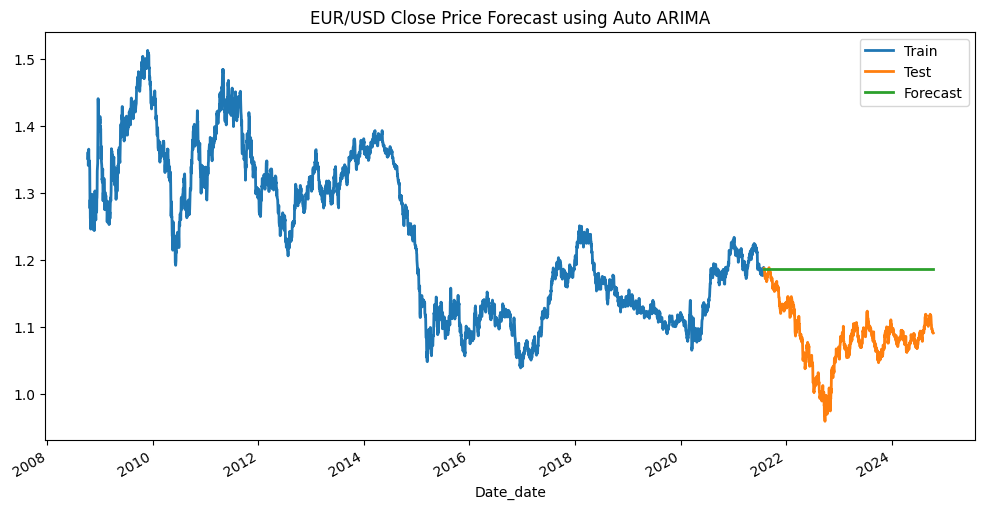

In [ ]:
plt.figure(figsize=(12, 6))
train.plot(label='Train', lw=2)
test.plot(label='Test', lw=2)
prediction_2["prediction"].plot(label='Forecast', lw=2)
plt.title('EUR/USD Close Price Forecast using Auto ARIMA')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

Text(0.5, 1.0, 'EUR/USD Close Price Forecast using Auto ARIMA')

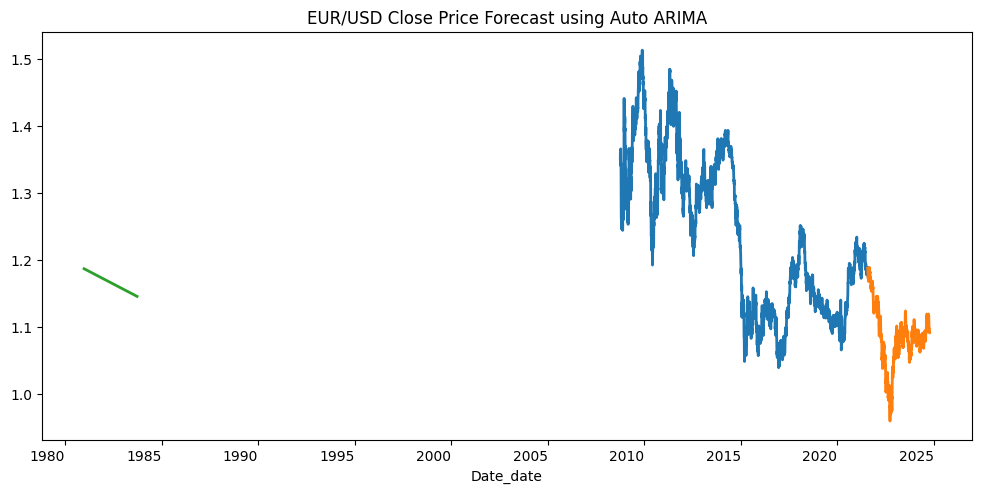

In [ ]:
arima = ARIMA(train, order=(p,d,q),trend='t')
arima = arima.fit()
forecast = arima.forecast(steps=len(test))
plt.figure(figsize=(12, 6))
train.plot(label='Train', lw=2)
test.plot(label='Test', lw=2)
forecast.plot(label='Forecast', lw=2)
plt.title('EUR/USD Close Price Forecast using Auto ARIMA')

In [ ]:
! pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.4/271.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:

In [ ]:
y

,close
Date_date,
2008-10-06,1.35150
2008-10-07,1.35700
2008-10-08,1.36080
2008-10-09,1.35568
2008-10-10,1.34091
...,...
2024-10-10,1.09334
2024-10-11,1.09353
2024-10-13,1.09230


In [ ]:
y2 = y

In [ ]:
full_date_range = pd.date_range(start=y.index.min(), end=y.index.max(), freq='D')
y = pd.DataFrame(y.reindex(full_date_range))
y

,close
2008-10-06,1.35150
2008-10-07,1.35700
2008-10-08,1.36080
2008-10-09,1.35568
2008-10-10,1.34091
...,...
2024-10-11,1.09353
2024-10-12,NaN
2024-10-13,1.09230
2024-10-14,1.09090


In [ ]:
full_date_range

DatetimeIndex(['2008-10-06', '2008-10-07', '2008-10-08', '2008-10-09',
               '2008-10-10', '2008-10-11', '2008-10-12', '2008-10-13',
               '2008-10-14', '2008-10-15',
               ...
               '2024-10-06', '2024-10-07', '2024-10-08', '2024-10-09',
               '2024-10-10', '2024-10-11', '2024-10-12', '2024-10-13',
               '2024-10-14', '2024-10-15'],
              dtype='datetime64[ns]', length=5854, freq='D')

In [ ]:
y['close'] = y['close'].fillna(method='ffill')
y

<ipython-input-38-3982e93245a3>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y['close'] = y['close'].fillna(method='ffill')


,close
2008-10-06,1.35150
2008-10-07,1.35700
2008-10-08,1.36080
2008-10-09,1.35568
2008-10-10,1.34091
...,...
2024-10-11,1.09353
2024-10-12,1.09353
2024-10-13,1.09230
2024-10-14,1.09090


In [ ]:
from darts.models import Theta
from darts import TimeSeries
y_ts = TimeSeries.from_series(y, fill_missing_dates=True, freq = "D")
train_ts, test_ts = y_ts[:int(len(y_ts)*0.8)],y_ts[int(len(y_ts)*0.8):]
theta = Theta()
theta.fit(train_ts)
forecast_values = theta.predict(len(test_ts))

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
theta.predict(10)

<TimeSeries (DataArray) (time: 10, component: 1, sample: 1)> Size: 80B
array([[[1.18978013]],

       [[1.18950975]],

       [[1.1889148 ]],

       [[1.18782148]],

       [[1.18554805]],

       [[1.18555466]],

       [[1.18605377]],

       [[1.17910079]],

       [[1.1766942 ]],

       [[1.17485616]]])
Coordinates:
  * time       (time) datetime64[ns] 80B 2021-08-02 2021-08-03 ... 2021-08-11
  * component  (component) object 8B 'close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Text(0.5, 1.0, 'EUR/USD Close Price Forecast using Theta')

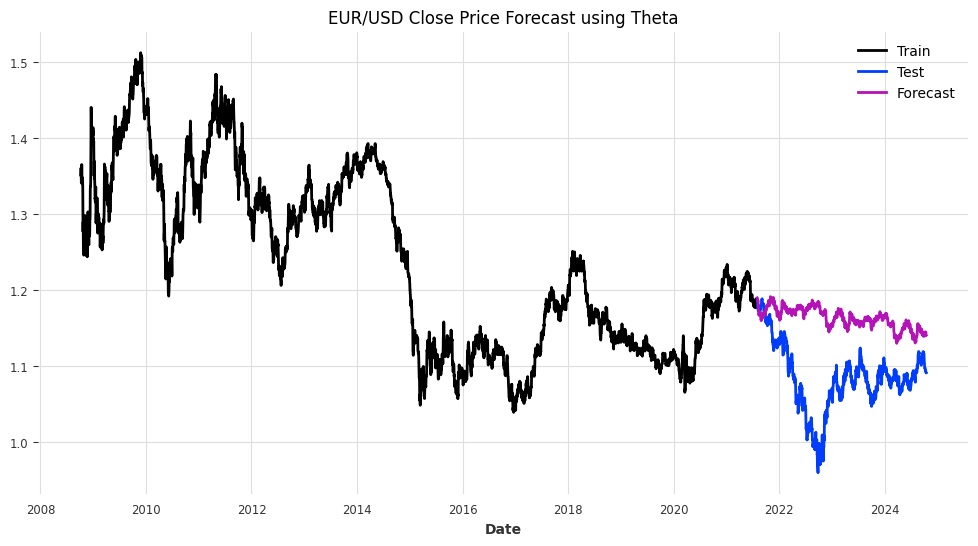

In [ ]:
plt.figure(figsize=(12, 6))
train_ts.plot(label='Train', lw=2)
test_ts.plot(label='Test', lw=2)
forecast_values.plot(label='Forecast', lw=2)
plt.xlabel('Date')
plt.title('EUR/USD Close Price Forecast using Theta')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
mae_arima = mean_absolute_error(test, prediction)
mse_arima = mean_squared_error(test, prediction)
rmse_arima = np.sqrt(mse_arima)

In [ ]:
print("Auto ARIMA Model Evaluation:")
print(f"MAE: {mae_arima}")
print(f"MSE: {mse_arima}")
print(f"RMSE: {rmse_arima}")

Auto ARIMA Model Evaluation:
MAE: 0.10251161515453634
MSE: 0.012442170608275164
RMSE: 0.11154447816129297


In [ ]:
mae_theta = mean_absolute_error(test_ts.values(), forecast_values.values())
mse_theta = mean_squared_error(test_ts.values(), forecast_values.values())
rmse_theta = np.sqrt(mse_theta)

In [ ]:
print("\nTheta Model Evaluation:")
print(f"MAE: {mae_theta}")
print(f"MSE: {mse_theta}")
print(f"RMSE: {rmse_theta}")


Theta Model Evaluation:
MAE: 0.0798717967958772
MSE: 0.008376373176977219
RMSE: 0.0915225282483893


In [ ]:
forecast_values.shape, test_ts.shape

((1171, 1, 1), (1171, 1, 1))

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
def get_plotly_data():
    z_data = pd.read_csv('eurusd_24h.csv')  # Load data from the CSV file
    z = z_data.values  # Convert DataFrame to a NumPy array
    sh_0, sh_1 = z.shape  # Get the shape of the data
    x, y = np.linspace(0, 1, sh_0), np.linspace(0, 1, sh_1)  # Create x and y axes
    return x, y, z  # Return x, y, and z data

# Generate the data
x, y, z = get_plotly_data()

# Create a Plotly figure
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

# Update the layout of the figure
fig.update_layout(title='EUR/USD', autosize=False, width=800, height=800, margin=dict(l=40, r=40, b=40, t=40))

# Display the figure
fig.show()  # This will open the plot in the default web browser


In [ ]:
len(df.index[:len(train_ts.values())]),len(train_ts.values())

(4683, 4683)

In [ ]:
fig = go.Figure()


fig.add_trace(go.Scatter(
    x=train_ts.time_index,
    y=train_ts.values(),
    mode='lines',
    name='Train',
    line=dict(color='blue', width=2),))


fig.add_trace(go.Scatter(
    x=test_ts.time_index,
    y=test_ts.values(),
    mode='lines',
    name='Test',
    line=dict(color='orange', width=2),))


fig.add_trace(go.Scatter(
    x=forecast_values.time_index,
    y=forecast_values.values(),
    mode='lines+markers',
    name='Forecast',
    line=dict(color='green', width=2, dash='dash'),
    marker=dict(size=8, symbol='circle')))


# Ensure the x-axis is displayed as a range of years
fig.update_xaxes(
    dtick="M12",)

fig.show()

In [ ]:
train_line = go.Scatter(x=df.index[:len(train_ts.values())],y=train_ts.values())
test_line = go.Scatter(x=df.index[-len(test_ts.values())+1:],y=test_ts.values())
forecast_line = go.Scatter(x=df.index[-len(test_ts.values())+1:],y=forecast_values.values())

fig = go.Figure(data=[train_line,test_line,forecast_line])
fig.update_layout(title='EUR/USD predictions', autosize=False, width=800, height=800, margin=dict(l=40, r=40, b=40, t=40))
fig.show()

In [ ]:
import plotly.io as pio
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [ ]:
fig = go.Figure()

# Add Train time series
fig.add_trace(go.Scatter(x=train_ts.time_index, y=train_ts.values().flatten(), mode='lines', name='Train', line=dict(width=2)))

# Add Test time series
fig.add_trace(go.Scatter(x=test_ts.time_index, y=test_ts.values().flatten(), mode='lines', name='Test', line=dict(width=2)))

# Add Forecast time series
fig.add_trace(go.Scatter(x=forecast_values.time_index, y=forecast_values.values().flatten(), mode='lines', name='Forecast', line=dict(width=2)))

# Update layout
fig.update_layout(title="EUR/USD Close Price Forecasting Using Theta Modelling",
                  #legend=dict(x=1.05, y=1, orientation="v"),
                  template="plotly_dark",
                  xaxis_tickformat='%b %Y',
                  xaxis_title=dict(text="Date", font=dict(size=16, color='white')),
                  yaxis_title=dict(text="Close Price", font=dict(size=16, color='white')),)
legend=dict(
        x=1.05, y=1, orientation="v",
        font=dict(size=20, color='white'),
        itemclick="toggleothers",
        itemdoubleclick="toggle"
    ),


fig.add_shape(
    type="line",
    x0="2022-10-01", x1="2022-10-01",
    y0=1.0, y1=1.5,
    line=dict(color="White", width=2, dash="dashdot"),
    xref='x', yref='y')

fig.add_annotation(
    x="2022-10-01",
    y=1.5,
    text="Important Event?",
    showarrow=True,
    arrowhead=2,
    ax=60,
    ay=-60,
    font=dict(color="white", size=20),
    bgcolor="rgba(0,0,0,0.7)",
    bordercolor="Red",
    borderwidth=2,
    arrowcolor="red"
)


fig.show()

In [ ]:
fig = go.Figure()

# Add Train time series
fig.add_trace(go.Scatter(x=train_ts.time_index, y=train_ts.values().flatten(), mode='lines', name='Train', line=dict(width=2)))

# Add Test time series
fig.add_trace(go.Scatter(x=test_ts.time_index, y=test_ts.values().flatten(), mode='lines', name='Test', line=dict(width=2)))

# Add Forecast time series
fig.add_trace(go.Scatter(x=forecast_values.time_index, y=forecast_values.values().flatten(), mode='lines', name='Forecast', line=dict(width=2)))

# Update layout
fig.update_layout(title="EUR/USD Close Price Forecast Using Theta",
                  #legend=dict(x=1.05, y=1, orientation="v"),
                  template="plotly_dark",
                  xaxis_tickformat='%b %Y',
                  xaxis_title=dict(text="Date", font=dict(size=16, color='white')),
                  yaxis_title=dict(text="Close Price", font=dict(size=16, color='white')),)
legend=dict(
        x=1.05, y=1, orientation="v",
        font=dict(size=12, color='white'),
        itemclick="toggleothers",
        itemdoubleclick="toggle"
    ),


fig.add_shape(
    type="line",
    x0="2022-10-01", x1="2022-10-01",
    y0=1.0, y1=1.5,
    line=dict(color="White", width=2, dash="dashdot"),
    xref='x', yref='y')

fig.add_annotation(
    x="2022-10-01",
    y=1.5,
    text="Important Event?",
    showarrow=True,
    arrowhead=2,
    ax=60,
    ay=-60,
    font=dict(color="white", size=12),
    bgcolor="rgba(0,0,0,0.7)",
    bordercolor="Red",
    borderwidth=2,
    arrowcolor="red")


fig.show()